<h1 align="center"> TP IoT - MS BGD 2016-2017</h1>
<h2><font color="#DF0174"> Géolocaliser des objets connectés à partir des antennes qui reçoivent leurs messages </font></h2>

In [13]:
# Imports des packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty
import folium
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
import statsmodels.api as sm
from IPython.display import display
from numpy.linalg import inv
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor

<h1><font color="#DF0174"> I) Preliminary steps ...</font></h1>
<h2> 1. Loading data ...</h2>

In [14]:
df_mess_train = pd.read_csv('mess_train_list.csv')
df_mess_test = pd.read_csv('mess_test_list.csv')
pos_train = pd.read_csv('pos_train_list.csv')

<h2>2. Data overview ... </h2>

In [15]:
print(pos_train.head())
print()
for device_position in pos_train[:5].iterrows():
    print("Lat : {} - Long : {}".format(device_position[1]['lat'], device_position[1]['lng']))

         lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.958554
3  39.730417 -104.968940
4  39.730417 -104.968940

Lat : 39.606689521599996 - Long : -104.958489931
Lat : 39.606689521599996 - Long : -104.958489931
Lat : 39.6377412341 - Long : -104.958554156
Lat : 39.7304174328 - Long : -104.96894015299999
Lat : 39.7304174328 - Long : -104.96894015299999


<h2> 3. Data visualization ... </h2>

In [16]:
MAX_RECORDS = 100

# 1 - Center the map around the first record location
map = folium.Map(location=[pos_train['lat'].ix[0],pos_train['lng'].ix[0]], zoom_start=12)

# 2  - Put the first devices location on the map
for device_position in pos_train[:MAX_RECORDS].iterrows():
    map.simple_marker(
        location = [device_position[1]['lat'], device_position[1]['lng']])

# 3  - Print the antenna locations on the map using orange dots
for antenna in df_mess_test[0:MAX_RECORDS].iterrows():
     map.circle_marker(location=[antenna[1]['bs_lat'] , antenna[1]['bs_lng']], radius=400,
                    popup='Base', line_color='#3186cc',
                    fill_color='orange')
    
display(map)

<h2> 4. Building the features matrix... </h2>

In [17]:
# On extrait toutes les bases qui ont reçu au moins un message dans la base de données de training et test
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), 
                      np.unique(df_mess_test['bsid']))
print('Nombre de bases ayant reçu au moins un message = ', listOfBs.size)

Nombre de bases ayant reçu au moins un message =  259


<h3> 4.1. Model 1 -  Features matrix of ones </h2>

In [18]:
def feat_mat_const(df_mess_train, listOfBs):
    # group data by message (objid)
    df_mess_by_objid = df_mess_train.groupby(['objid'], as_index=False) 
    nb_mess = len(np.unique(df_mess_train['objid']))
    # feature matrix contains a row for each message, and a column for each antenna
    df_feat = pd.DataFrame(np.zeros((nb_mess, len(listOfBs))), columns = listOfBs) 
    idx = 0

    #Inserts 1 into every column correponsding to an antenna having received a given message
    for key, elmt in df_mess_by_objid:
        df_mess_by_objid.get_group(key)
        df_feat.loc[idx, df_mess_by_objid.get_group(key)['bsid']] = 1
        idx = idx + 1
    
    return df_feat

In [19]:
# This matrix will be used as our training set
df_feat = feat_mat_const(df_mess_train, listOfBs)

<h3> 4.2. Model 2 -  Features matrix of RSSI </h2>

In [20]:
def feat_mat_constRSSI(df_mess_train, listOfBs):

    df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=True) # group data by message (objid)
    nb_mess = len(np.unique(df_mess_train['objid']))
    df_feat = pd.DataFrame(np.zeros((nb_mess,len(listOfBs))), columns = listOfBs) # feature matrix
    idx = 0

    for key, elmt in df_mess_bs_group:
        df_mess_bs_group.get_group(key)
        df_feat.loc[idx, df_mess_bs_group.get_group(key)['bsid']] = df_mess_bs_group.get_group(key)['rssi'].values
        idx = idx + 1
    
    return df_feat

In [21]:
df_feat_rssi = feat_mat_constRSSI(df_mess_train, listOfBs)

In [22]:
ind = df_feat_rssi[(df_feat_rssi[df_feat_rssi == 0].isnull().sum(axis=1)) > 2].index

pos_train_no_null = pos_train.ix[ind, :]
df_feat_rssi_no_null = df_feat_rssi[(df_feat_rssi[df_feat_rssi == 0].isnull().sum(axis=1)) > 2]

In [23]:
print("Value minimum de RSSI dans toute la matrice: %s" % df_feat_rssi_no_null.min().min())
df_feat_rssi_no_null[df_feat_rssi_no_null == 0] = -200
print("Value minimum de RSSI dans toute la matrice: %s" % df_feat_rssi_no_null.max().max())

Value minimum de RSSI dans toute la matrice: -155.0
Value minimum de RSSI dans toute la matrice: -69.0


<h2> 5. Defining a loss function... </h2>

In [24]:
def ground_truth_const(df_mess_train, pos_train):

    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train

    ground_truth_lat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
    
    return ground_truth_lat, ground_truth_lng

In [25]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

In [26]:
ground_truth_lat_not_null = ground_truth_lat[ind]
ground_truth_lng_not_null = ground_truth_lng[ind]

In [27]:
# Fonctions nécessaires à l'évaluation des résultats
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m, 0:2], vec_coord[m, 2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

# Calcul de la distance entre la vraie coordonnée et la coordonée estimée.
def eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    return err_vec

<h3> 5.1 Critère d'évaluation </h3>

In [28]:
def print_percentile_error(quantile=80):
    err = np.percentile(err_vec, quantile)
    listErr.append(err)
    print("In {}% of the cases, the error is less than {} km.".format(quantile,err/1000) )

In [29]:
listErr = []
df_erreur = pd.DataFrame()

<h1> <font color="#DF0174">II) Trying out various ML algorithms... <font></h1>

<h3> 1.  Nearest Neighbors Regression </h3>

In [30]:
X_train = np.array(df_feat_rssi_no_null);
# 15 plus proches voisins
# on choisit la distance comme critère de poid, avec comme métrique, la norme L1
clf_knn = KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2)
y_pred_lng = cross_val_predict(clf_knn, X_train, ground_truth_lng_not_null, cv=10)
y_pred_lat = cross_val_predict(clf_knn, X_train, ground_truth_lat_not_null, cv=10)
err_vec = eval_geoloc(ground_truth_lat_not_null , ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_KNR'] = err_vec
print_percentile_error()
# clf_knn.fit(X_train, clf_knn)

In 80% of the cases, the error is less than 2.337937017575724 km.


### 1.1. Plot de la courbes des erreurs cumulées

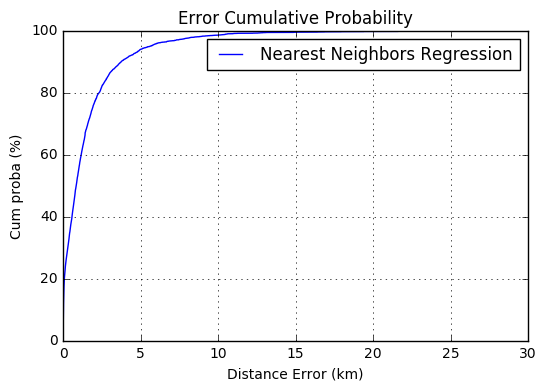

In [31]:
def plot_cumulated_errors(err_vec, algo, bins=50000):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( [algo])
    
plot_cumulated_errors(err_vec, "Nearest Neighbors Regression")

<h3>2.  Bagging regressor </h3>

In [32]:
clf_bag = BaggingRegressor(base_estimator=clf_knn,
                           n_estimators=35,
                           bootstrap=True,
                           oob_score=True,
                           random_state=42)

y_pred_lng = cross_val_predict(clf_bag, X_train, ground_truth_lng_not_null, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(clf_bag, X_train, ground_truth_lat_not_null, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat_not_null , ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_KNR'] = err_vec
print_percentile_error()

In 80% of the cases, the error is less than 2.31215594311293 km.


### 2.1. Plot de la courbes des erreurs cumulées

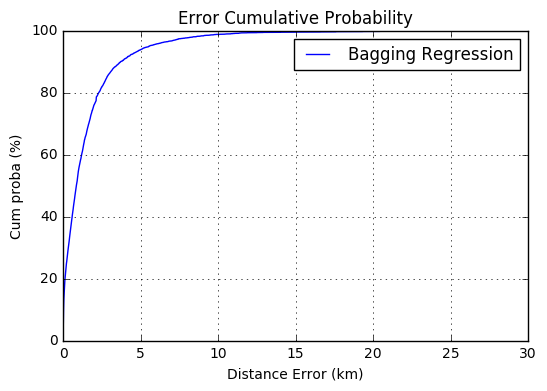

In [34]:
def plot_cumulated_errors(err_vec, algo, bins=50000):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( [algo])
    
plot_cumulated_errors(err_vec, "Bagging Regression")

<h3>3.  ExtraTrees regressor </h3>

In [40]:
from sklearn.ensemble import ExtraTreesRegressor

X_train = np.array(df_feat_rssi_no_null);

# Build a forest and compute the feature importances
extra_trees = ExtraTreesRegressor(n_estimators=50, max_features='sqrt', max_depth=500)
y_pred_lng = cross_val_predict(extra_trees, X_train, ground_truth_lng_not_null, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(extra_trees, X_train, ground_truth_lat_not_null, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat_not_null, ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_ExtraTrees_RSSI'] = err_vec
print_percentile_error()

In 80% of the cases, the error is less than 2.43117547380859 km.


### 3.1. Plot de la courbes des erreurs cumulées

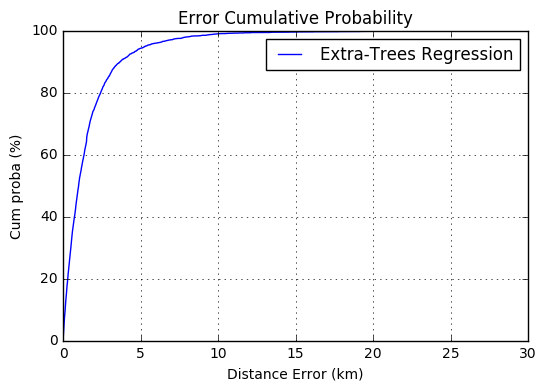

In [41]:
def plot_cumulated_errors(err_vec, algo, bins=50000):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( [algo])
    
plot_cumulated_errors(err_vec, "Extra-Trees Regression")

<h3> 4. Linear Regression </h3>

In [43]:
reg = linear_model.LinearRegression()
y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng_not_null, cv=8, n_jobs=-1)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat_not_null, cv=8, n_jobs=-1)
err_vec = eval_geoloc(ground_truth_lat_not_null, ground_truth_lng_not_null, y_pred_lat, y_pred_lng)
df_erreur['err_LR'] = err_vec
print_percentile_error()

In 80% of the cases, the error is less than 5.526628614644621 km.


### 4.1. Plot de la courbes des erreurs cumulées

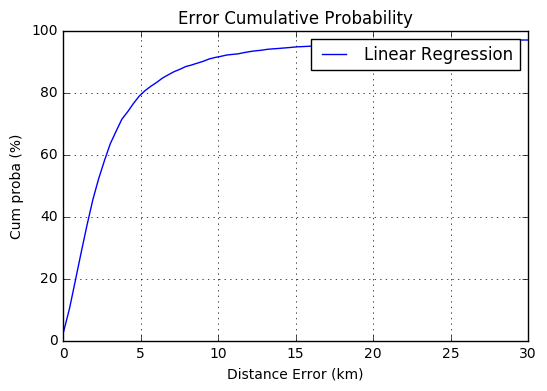

In [44]:
def plot_cumulated_errors(err_vec, algo, bins=50000):
    values, base = np.histogram(err_vec, bins=50000)
    cumulative = np.cumsum(values) 
    plt.figure();
    plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
    plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
    plt.title('Error Cumulative Probability'); plt.legend( [algo])
    
plot_cumulated_errors(err_vec, "Linear Regression")
    

# Conclusions et Synthèse

*  La régression de Bagging Boosting basée sur des kNN donne les meilleurs résultats.
*  L'ajout des RSSI dans la matrice de features améliore pas les données.



In [48]:
d = {'Erreur à 80% en km' : listErr}
df = pd.DataFrame(d)
df['Erreur à 80% en km'] = df['Erreur à 80% en km']/1000
df.rename(index={0: 'kNN', 1: 'Bagging Boosting', 2: 'Extra-Trees', 3: 'Linear Regression'})

,Erreur à 80% en km
kNN,2.337937
Bagging Boosting,2.312156
Extra-Trees,2.431175
Linear Regression,5.526629


<h1> <font color="#DF0174">III) Export des résultats en CSV <font></h1>

In [ ]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat, ground_truth_lat, ground_truth_lng, df_test
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    clf = KNeighborsRegressor(n_neighbors=3, weights='distance', algorithm='auto', p=2)

    clf.fit(X_train, ground_truth_lat);
    y_pred_lat = clf.predict(df_test) 

    clf.fit(X_train, ground_truth_lng);
    y_pred_lng = clf.predict(df_test) 
    
    return y_pred_lat, y_pred_lng

# *******  Matrice des features ******************
df_feat_test = feat_mat_constRSSI(df_mess_test, listOfBs)
df_feat_test[df_feat_test == 0] = -200

# ************** Ground Truth *********************
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

# ************** Prédiction ***********************
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat_test)


test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

In [ ]:
def ground_truth_indexed(pos_train):
    gb = pos_train.groupby(['objid']).mean()
    ground_truth_lat = gb['lat']
    ground_truth_lng = gb['lng']
    
    return ground_truth_lat, ground_truth_lng

In [ ]:
class LOO:
    def feat_mat_const_foo(self, df_mess_train, listOfBs):
        df_mess_bs_group = df_mess_train.groupby(['objid'], as_index=True) # group data by message (objid)
        objids = np.unique(df_mess_train['objid'])
        nb_mess = len(objids)
        df_feat = pd.DataFrame(np.zeros((nb_mess, len(listOfBs))), columns = listOfBs, index=objids)

        for key, elmt in df_mess_bs_group:
            df_mess_bs_group.get_group(key)
            g = df_mess_bs_group.get_group(key)
            df_feat.loc[g['objid'], g['bsid']] = g['rssi'].values

        return df_feat

    
    def fit(self, df_mess_train, pos_train, listOfBs):
        self.clf_lng = []
        self.clf_lat = []
        df_mess_train_no_null = df_mess_train.copy()
        
        # Put -200 where we have 0 (no station got the message)
        df_feat = self.feat_mat_const_foo(df_mess_train_no_null, listOfBs)
        
        # Remove objects that have been received by less than 2 stations
        ind = df_feat[(df_feat[df_feat == 0].isnull().sum(axis=1)) > 2].index
        df_feat[df_feat == 0] = -200
        
        pos_train_no_null = pos_train.copy()
        
        for i, row in df_mess_train.iterrows():
            if row['objid'] not in ind:
                df_mess_train_no_null.drop(i, inplace=True)
                pos_train_no_null.drop(i, inplace=True)
                try:
                    df_feat.drop(row['objid'], inplace=True)
                except:
                    pass
        
        
        pos_train_no_null['objid'] = df_mess_train_no_null['objid']
        ground_truth_lat, ground_truth_lng = ground_truth_indexed(df_mess_train_no_null, pos_train_no_null)

        params = {'n_neighbors':3, 'weights':'distance', 'algorithm':'auto', 'p':2}
        for did in np.unique(df_mess_train_no_null['did']):
            print(did)
            objids_train = df_mess_train_no_null[df_mess_train_no_null['did'] != did]['objid']

            X = np.array(df_feat.ix[objids_train])
            y_lat = ground_truth_lat.ix[objids_train]
            y_lng = ground_truth_lng.ix[objids_train]
            
            self.clf_lat.append(KNeighborsRegressor(**params).fit(X, y_lat))
            self.clf_lng.append(KNeighborsRegressor(**params).fit(X, y_lng))
        
        return self
            
            
            
    def predict(self, df_mess_test, listOfBs):
        df_feat_test = self.feat_mat_const_foo(df_mess_test, listOfBs)
        df_feat_test[df_feat_test == 0] = -200
        
        nb_clf = len(self.clf_lng)
        
        sum_lat = np.zeros(df_feat_test.shape[0])
        sum_lng = np.zeros(df_feat_test.shape[0])
        
        for i in range(nb_clf):
            print(i)
            sum_lat += self.clf_lat[i].predict(df_feat_test)
            sum_lng += self.clf_lng[i].predict(df_feat_test)
            
        mean_lat = sum_lat / nb_clf
        mean_lng = sum_lng / nb_clf
        
        return mean_lat, mean_lng

In [ ]:
loo = LOO()

In [95]:
df_mess_train = pd.read_csv('data/mess_train_list.csv')
df_mess_test = pd.read_csv('data/mess_test_list.csv')
pos_train = pd.read_csv('data/pos_train_list.csv')

loo.fit(df_mess_train, pos_train, listOfBs)

In [130]:
y_pred_train_lat, y_pred_train_lng = loo.predict(df_mess_train[::390], listOfBs)

In [131]:
err_vec = eval_geoloc(pos_train[::390]['lat'], pos_train[::390]['lng'], y_pred_train_lat, y_pred_train_lng)
print_percentile_error()